## Preprocessing and Modeling

### Import libriaries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from mlxtend.preprocessing import DenseTransformer
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
import requests

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)

### Load data

1. Subreddit - Dogs, dog lovers

In [2]:
df_dogs = pd.read_csv('../data/dogs.csv')
df_dogs = df_dogs[['subreddit','title','selftext']]
df_dogs.shape

(1127, 3)

2. Subreddit - Dogfree, dog haters

In [37]:
df_dogfree = pd.read_csv('../data/Dogfree.csv')
df_dogfree = df_dogfree[['subreddit','title','selftext']]
df_dogfree.shape

(1118, 3)

3. Join datasets

In [58]:
df = pd.concat([df_dogs, df_dogfree])
df.shape

(2245, 3)

In [27]:
df.head(2)

,subreddit,title,selftext
0,dogs,[HELP] Heart Murmur heard in 11 year old,"My Boston terrier is 11 and has been slowing down quite a bit he last month or so. Eating drinking and using the bathroom just fine, just walks and play time with me are shorter.\n\nConcerned, I took him in and the vet heard a heart murmur. He’s needing some dental work and the vet said the heart murmur trumps his teeth. \n\nI have an echo gram scheduled in a couple weeks to see what’s going on. To see if his heart is even ok enough to bring him under for his dental stuff. Vet didn’t seem as concerned as I was with this news, but I’m a mess. I’m out of town for work and mom took my dog to her old boys vet, so being half a country away is killing me. \n\nFor those who have dogs with a heart murmur, what can I expect? I understand medicine is an option. I just can’t stop dwelling on the fact I’m losing my best friend."
1,dogs,[vent] [discussion] educate yourself before you judge my dog,"This just happened a few minutes ago. I’m livid but there’s really no one to talk to since I don’t know anyone else with a shepherd. \n\nI was with my GSD in the parking garage of my building after coming in from a walk. An elderly couple were getting out of their car across from the elevator while another woman was getting out with her little 8-ish pound dog. \n\nMy dog barked, didn’t growl. The dog woman didn’t run away, she just laughed a little and said goodbye while she went outside. \n\nThe woman from the couple twisted her face up and told me not to hold the door for her. We ended up getting out of separate elevators on the same floor. As I’m going in to my apartment I heard her bitching to her husband that big dogs shouldn’t be allowed in the building. \n\nFirst of all lady, you nothing about my big dog, or about me, so shut up. My dog was not aggressive. If he wanted to eat that dog he would have. His hackles were not up, his tail was loose and curved up, and his body was not tense. No aggression. He can’t talk so he barked. \n\nSecond of all, golden retrievers are bigger than my dog, so you’re saying they shouldn’t be allowed here? Or are you just prejudiced against German Shepherds? Almost every small dog we meet here barks at my dog but no one ever corrects them or says they shouldn’t be allowed. \n\nSo educate yourself, please, before you make any assumption from your obviously limited knowledge. \n\nNow, should I contact management to let them know this woman might complain? She seems like the passive aggressive type to write a sternly worded letter. I rent, not own."


### EDA

The dataset contains 2245 rows and 3 columns:
 - subreddit, which subreddit a post belongs to, dogs/dogfree
 - title, title of a post
 - selftext, text of a post if post contains it

In [59]:
df.isnull().sum().sort_values(ascending=False)

selftext     618
title        0  
subreddit    0  
dtype: int64

618 null values because some posts don't have any text. 
I'll join title and post's text to one text for analysis so I'll replace all nan values with empty string ''.

In [60]:
df.replace(np.nan, '', inplace=True)

In [61]:
df['text'] = df['title']  + ' ' + df['selftext']

### Binarizing Target Variable

I'll need to convert the target variable 'Subreddit' to a binary variable.

In [62]:
df['subreddit'].value_counts()

dogs       1127
Dogfree    1118
Name: subreddit, dtype: int64

In [63]:
# create column with value 1 if Aww and 0 if Dogfree
df['subreddit_class'] = [1 if i == 'dogs' else 0 for i in df['subreddit']]

In [64]:
# Check it out
df['subreddit_class'].value_counts()

1    1127
0    1118
Name: subreddit_class, dtype: int64

In [65]:
df.head(2)

,subreddit,title,selftext,text,subreddit_class
0,dogs,[HELP] Heart Murmur heard in 11 year old,"My Boston terrier is 11 and has been slowing down quite a bit he last month or so. Eating drinking and using the bathroom just fine, just walks and play time with me are shorter.\n\nConcerned, I took him in and the vet heard a heart murmur. He’s needing some dental work and the vet said the heart murmur trumps his teeth. \n\nI have an echo gram scheduled in a couple weeks to see what’s going on. To see if his heart is even ok enough to bring him under for his dental stuff. Vet didn’t seem as concerned as I was with this news, but I’m a mess. I’m out of town for work and mom took my dog to her old boys vet, so being half a country away is killing me. \n\nFor those who have dogs with a heart murmur, what can I expect? I understand medicine is an option. I just can’t stop dwelling on the fact I’m losing my best friend.","[HELP] Heart Murmur heard in 11 year old My Boston terrier is 11 and has been slowing down quite a bit he last month or so. Eating drinking and using the bathroom just fine, just walks and play time with me are shorter.\n\nConcerned, I took him in and the vet heard a heart murmur. He’s needing some dental work and the vet said the heart murmur trumps his teeth. \n\nI have an echo gram scheduled in a couple weeks to see what’s going on. To see if his heart is even ok enough to bring him under for his dental stuff. Vet didn’t seem as concerned as I was with this news, but I’m a mess. I’m out of town for work and mom took my dog to her old boys vet, so being half a country away is killing me. \n\nFor those who have dogs with a heart murmur, what can I expect? I understand medicine is an option. I just can’t stop dwelling on the fact I’m losing my best friend.",1
1,dogs,[vent] [discussion] educate yourself before you judge my dog,"This just happened a few minutes ago. I’m livid but there’s really no one to talk to since I don’t know anyone else with a shepherd. \n\nI was with my GSD in the parking garage of my building after coming in from a walk. An elderly couple were getting out of their car across from the elevator while another woman was getting out with her little 8-ish pound dog. \n\nMy dog barked, didn’t growl. The dog woman didn’t run away, she just laughed a little and said goodbye while she went outside. \n\nThe woman from the couple twisted her face up and told me not to hold the door for her. We ended up getting out of separate elevators on the same floor. As I’m going in to my apartment I heard her bitching to her husband that big dogs shouldn’t be allowed in the building. \n\nFirst of all lady, you nothing about my big dog, or about me, so shut up. My dog was not aggressive. If he wanted to eat that dog he would have. His hackles were not up, his tail was loose and curved up, and his body was not tense. No aggression. He can’t talk so he barked. \n\nSecond of all, golden retrievers are bigger than my dog, so you’re saying they shouldn’t be allowed here? Or are you just prejudiced against German Shepherds? Almost every small dog we meet here barks at my dog but no one ever corrects them or says they shouldn’t be allowed. \n\nSo educate yourself, please, before you make any assumption from your obviously limited knowledge. \n\nNow, should I contact management to let them know this woman might complain? She seems like the passive aggressive type to write a sternly worded letter. I rent, not own.","[vent] [discussion] educate yourself before you judge my dog This just happened a few minutes ago. I’m livid but there’s really no one to talk to since I don’t know anyone else with a shepherd. \n\nI was with my GSD in the parking garage of my building after coming in from a walk. An elderly couple were getting out of their car across from the elevator while another woman was getting out with her little 8-ish pound dog. \n\nMy dog barked, didn’t growl. The dog woman didn’t run away, she just laughed a little and said 

### Visualization

To explore the most common words, I’ve created word clouds.

In [66]:
#define a function for creating World clouds
def world_could(text, filename, mask=None):
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(max_font_size=72,
                      max_words=150,
                      background_color="white",
                      stopwords = stopwords.words('english') + ['help','discussion'],
                      mask=mask
                      ).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.axis("off");
    plt.show();
    wordcloud.to_file('../images/'+filename+'.png');

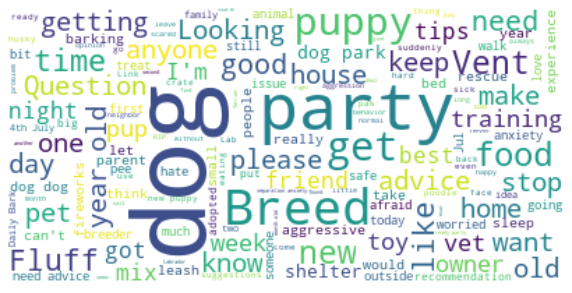

In [67]:
text_dogs = " ".join(text for text in df['title'][(df['subreddit'] == 'dogs')]) 
world_could(text_dogs,'dogs')

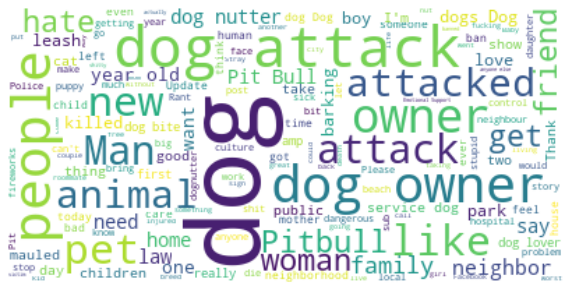

In [68]:
text_dogfree = " ".join(text for text in df['title'][(df['subreddit'] == 'Dogfree')]) 
world_could(text_dogfree,'dog_free')

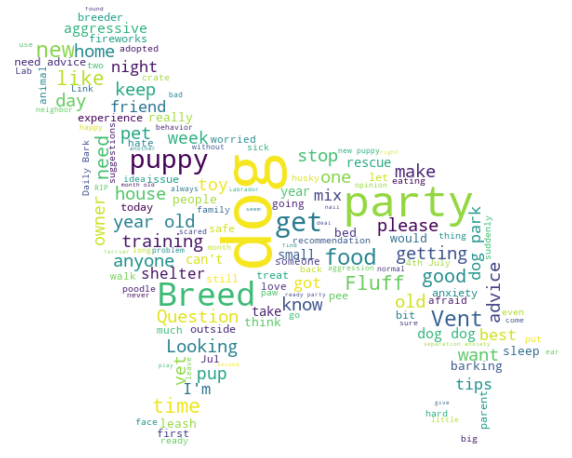

In [69]:
url_dog = 'https://render.fineartamerica.com/images/rendered/default/print/8.000/6.375/break/images-medium-5/golden-retriever-dog-vector-silhouette-helgamariah.jpg'
mask_dog = np.array(Image.open(requests.get(url_dog, stream=True).raw))
world_could(text_dogs,'dogs_shape', mask_dog)

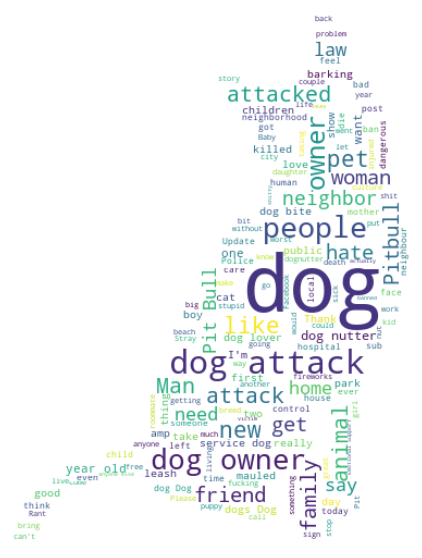

In [70]:
url_cat = 'https://images-na.ssl-images-amazon.com/images/I/31CaLdDFlKL.jpg'
mask_cat = np.array(Image.open(requests.get(url_cat, stream=True).raw))
world_could(text_dogfree,'dog_free_shape',mask_cat)

### Pre-processing

In [71]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

Define a function that takes text, tokenizes and stemmed it:

In [72]:
def steam_text(text):    
    stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    text_token = tokenizer.tokenize(text.lower())  #convert characters to lower case  
    return ' '.join(map(lambda x: stemmer.stem(x), text_token))

In [73]:
df['stemmed_text'] = df['text'].apply(steam_text)

### Model Prep: Create our features matrix (X) and target vector (y)

As independent variable I use combined column(post's title and post's text), it works better rather than just title.

In [74]:
X = df['stemmed_text'] 
y = df['subreddit_class']

### Model Prep: Train/test split

With all the data cleaned, I’ll split the data in 75% training and 25% testing using train_test_split()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    random_state=42)

### Determining Baseline Accuracy Score

Accuracy Score is the metric we will be using to measure the quality of our model. 
Our Baseline model accuracy is 0.5018 or 50.18%, we should build the classifier to beat the baseline accuracy. 

In [78]:
y_test.value_counts(normalize=True)

1    0.501779
0    0.498221
Name: subreddit_class, dtype: float64


### Modeling with Gridsearching Hyperparameters

In order to find the best modeling method I fit three models to the testing data using Gridsearch to find the best hyperparameters. 
I built different models to chose the best one:
 - Logistic Regression (CountVectorizer and TfidfVectorizer)
 - Multinomial Naive Bayes with CountVectorizer
 - Random Forest (CountVectorizer and TfidfVectorizer)


### Model 1. Logistic regression

**Logistic regression with CountVectorizer**

In [174]:
pipe_lr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

params_lr_cvec = {
    'cvec__stop_words':   [None, 'english'],
    'cvec__max_features': [1000, 1500, 2000, 3000, 4000, 5000], 
    'cvec__ngram_range':  [(1,1), (1,2), (1,3)],
    'lr__penalty':        ['l2','l1'],
    'lr__C':              [.5, .01, 1],
    'lr__random_state':   [42] 
    
}

gs_lr_cvec = GridSearchCV(pipe_lr_cvec,
                        param_grid=params_lr_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lr_cvec.fit(X_train, y_train);


print(f'GridSearch Best Params: {gs_lr_cvec.best_params_}')
print('Train Score:', gs_lr_cvec.score(X_train, y_train))
print('Test Score:', gs_lr_cvec.score(X_test, y_test))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done 1080 out of 1080 | elapsed:  8.7min finished


GridSearch Best Params: {'cvec__max_features': 4000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'lr__C': 0.5, 'lr__penalty': 'l1', 'lr__random_state': 42}
Train Score: 0.9910873440285205
Test Score: 0.9483985765124555


**Logistic regression with TfidfVectorizer**

In [175]:
pipe_lr_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params_lr_tf = {
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [1000, 2000, 3000, 4000], 
    'tf__ngram_range':  [(1, 1), (1, 2), (1, 3)], 
    'lr__penalty':      ['l2', 'l1'],
    'lr__C':            [.5, .01, 1],
    'lr__random_state': [42] 
}
gs_lr_tf = GridSearchCV(pipe_lr_tf, 
                        param_grid=params_lr_tf,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lr_tf.fit(X_train, y_train)


print(f'GridSearch Best Params: {gs_lr_tf.best_params_}')
print('Train Score:', gs_lr_tf.score(X_train, y_train))
print('Test Score:', gs_lr_tf.score(X_test, y_test))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  5.4min finished


GridSearch Best Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__random_state': 42, 'tf__max_features': 1000, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train Score: 0.976232917409388
Test Score: 0.9537366548042705


### Model 2. Naive Bayes

**Multinomial Naive Bayes with CountVectorizer**

In [176]:
pipe_multiniminal_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('multiniminal_nb', MultinomialNB())
])

params_multiniminal_nb_cvec = {
    'cvec__stop_words':           [None, 'english'],
    'cvec__max_features':         [100, 500, 1000, 2000, 3000, 4000], 
    'cvec__ngram_range':          [(1, 1), (1, 2), (1, 3)],
    'multiniminal_nb__alpha':     [0], # 2, 5, .5, 1
    'multiniminal_nb__fit_prior': [True, False]
}

gs_multiniminal_nb_cvec = GridSearchCV(pipe_multiniminal_nb_cvec, 
                        param_grid=params_multiniminal_nb_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)
    
gs_multiniminal_nb_cvec.fit(X_train, y_train)


print(f'GridSearch Best Params: {gs_multiniminal_nb_cvec.best_params_}')
print('Train Score:', gs_multiniminal_nb_cvec.score(X_train, y_train))
print('Test Score:', gs_multiniminal_nb_cvec.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:  2.6min finished


GridSearch Best Params: {'cvec__max_features': 1000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'multiniminal_nb__alpha': 0, 'multiniminal_nb__fit_prior': False}
Train Score: 0.9477124183006536
Test Score: 0.9234875444839857


### Model 3. Random Forest

**Random Forest with CountVectorizer**

In [177]:
pipe_rf_cvec = Pipeline([
    ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier())
])

params_rf_cvec = {
    'cvec__stop_words':   [None, 'english'],
    'cvec__max_features': [500, 1000, 2000], 
    'cvec__ngram_range':  [(1, 1), (1, 2)], 
    'rf__n_estimators':   [25, 50, 150], 
    'rf__criterion':      ['gini'],
    'rf__max_depth':      [5], 
    'rf__random_state':   [42]
}

gs_rf_cvec = GridSearchCV(pipe_rf_cvec,
                          param_grid=params_rf_cvec,
                          cv=5,
                          n_jobs=2,
                          verbose=1)

gs_rf_cvec.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_rf_cvec.best_params_}')
print('Train Score:', gs_rf_cvec.score(X_train, y_train))
print('Test Score:', gs_rf_cvec.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:   53.9s finished


GridSearch Best Params: {'cvec__max_features': 500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__n_estimators': 150, 'rf__random_state': 42}
Train Score: 0.9625668449197861
Test Score: 0.9430604982206405


**Random Forest with TfidfVectorizer**

In [178]:
pipe_rf_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

params_rf_tf={
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [1000, 2000, 3000],
    'tf__ngram_range':  [(1,1), (1, 2)],
    'tf__smooth_idf':   [True, False],
    'rf__n_estimators': [25, 50, 100], 
    'rf__criterion':    ['gini'], #'entropy',
    'rf__max_depth':    [3, 5], 
    'rf__random_state': [42]
}
gs_rf_tf = GridSearchCV(pipe_rf_tf,
                        param_grid=params_rf_tf, 
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_rf_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_rf_tf.best_params_}')
print('Train Score:', gs_rf_tf.score(X_train, y_train))
print('Test Score:', gs_rf_tf.score(X_test, y_test))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   54.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  3.6min finished


GridSearch Best Params: {'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__n_estimators': 100, 'rf__random_state': 42, 'tf__max_features': 1000, 'tf__ngram_range': (1, 1), 'tf__smooth_idf': False, 'tf__stop_words': 'english'}
Train Score: 0.9548425430778372
Test Score: 0.9199288256227758


### Models Evaluation

In [146]:
# Define confusin matrix function 
def conf_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test) 
    cm = confusion_matrix(y_test, y_hat)  # get confusion matrix data
    tn, fp, fn, tp = cm.ravel()           # extract elements of confusion matrix
    
    # Convert Confusion Matrix to DataFrame
    cm_df = pd.DataFrame(cm,
                         columns = ['Predict Dog Haters (y=0)','Predict Dog Lovers (y=1)'],
                         index = ['Actual Dog Haters (y=0)', 'Actual Dog Lovers (y=1)'])
    
    return cm_df
    
def conf_matrix_metrics(model, X_test, y_test):
    y_hat = model.predict(X_test) 
    cm = confusion_matrix(y_test, y_hat)  
    tn, fp, fn, tp = cm.ravel()           
    #calculate metrics 
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    specificity = tn/ (tn + fp)
    precision = tp /(tp + fp)
    
    return {'accuracy': np.round(accuracy,3),
            'sensitivity': np.round(sensitivity,3),
            'specificity': np.round(specificity,3),
            'precision': np.round(precision,3)}

**Logistic regression with CountVectorizer**

In [149]:
print(conf_matrix_metrics(gs_lr_cvec, X_test, y_test))
conf_matrix(gs_lr_cvec, X_test, y_test)

{'accuracy': 0.948, 'sensitivity': 0.95, 'specificity': 0.946, 'precision': 0.947}


,Predict Dog Haters (y=0),Predict Dog Lovers (y=1)
Actual Dog Haters (y=0),265,15
Actual Dog Lovers (y=1),14,268


**Logistic regression with TfidfVectorizer**

In [147]:
print(conf_matrix_metrics(gs_lr_tf, X_test, y_test))
conf_matrix(gs_lr_tf, X_test, y_test)

{'accuracy': 0.954, 'sensitivity': 0.961, 'specificity': 0.946, 'precision': 0.948}


,Predict Dog Haters (y=0),Predict Dog Lovers (y=1)
Actual Dog Haters (y=0),265,15
Actual Dog Lovers (y=1),11,271


**Multinomial Naive Bayes with CountVectorizer**

In [152]:
print(conf_matrix_metrics(gs_multiniminal_nb_cvec, X_test, y_test))
conf_matrix(gs_multiniminal_nb_cvec, X_test, y_test)

{'accuracy': 0.923, 'sensitivity': 0.947, 'specificity': 0.9, 'precision': 0.905}


,Predict Dog Haters (y=0),Predict Dog Lovers (y=1)
Actual Dog Haters (y=0),252,28
Actual Dog Lovers (y=1),15,267


**Random Forest with CountVectorizer**

In [153]:
print(conf_matrix_metrics(gs_rf_cvec, X_test, y_test))
conf_matrix(gs_rf_cvec, X_test, y_test)

{'accuracy': 0.943, 'sensitivity': 0.947, 'specificity': 0.939, 'precision': 0.94}


,Predict Dog Haters (y=0),Predict Dog Lovers (y=1)
Actual Dog Haters (y=0),263,17
Actual Dog Lovers (y=1),15,267


**Random Forest with TfidfVectorizer**

In [154]:
print(conf_matrix_metrics(gs_rf_tf, X_test, y_test))
conf_matrix(gs_rf_tf, X_test, y_test)

{'accuracy': 0.92, 'sensitivity': 0.901, 'specificity': 0.939, 'precision': 0.937}


,Predict Dog Haters (y=0),Predict Dog Lovers (y=1)
Actual Dog Haters (y=0),263,17
Actual Dog Lovers (y=1),28,254


Logistic regression with TfidfVectorizer has the best accuracy score - 95.4%. 536 post out of 579 were correctly classified.

### Feature importance

The Logistic Regression Classification model is the easiest to interpret. We can extract coefficients. 

In [232]:
pd.DataFrame(list(zip(gs_lr_tf.best_estimator_[0].get_feature_names(),(gs_lr_tf.best_estimator_[1].coef_[0]))),
            columns=['word','coef']).sort_values('coef',ascending=False).head(5)

,word,coef
445,help,5.765303
652,parti,4.812514
240,discuss,4.729457
939,vet,2.615551
50,ani,2.071909


In [233]:
pd.DataFrame(list(zip(gs_lr_tf.best_estimator_[0].get_feature_names(),(gs_lr_tf.best_estimator_[1].coef_[0]))),
            columns=['word','coef']).sort_values('coef',ascending=True).head(5)

,word,coef
80,attack,-2.942621
246,dog,-2.639061
52,anim,-2.497448
380,fuck,-2.313820
792,shit,-1.950404


As we can see top stem predictors:
- for Dog lovers: help, parti, discuss, vet, ani
- for Dog haters: attack, dog, anim, fuck, shit

### Conclusion and Recommendations

In spite of the fact that I chose  highly correlated subreddits all three models (Logistic Regression, Naive Bayes and Random Forest) showed at least 1.7x better accuracy score than the baseline.<br>
The best model is Logistic Regression, we can predict with an accuracy of about 95.4% where a given post came from, 19 out of 20 posts. 






Further improvements for the model includes:
 - better work with hyperparameters to reduce overfitting for Random Forest Classifier 